this is the new code

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load data
df = pd.read_csv("emotions.csv")

print(df.head())

# Remove unnamed columns if any
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Ensure label column is clean
df['label'] = df['label'].str.upper()
print("Labels:", df['label'].unique())

# Encode labels to numeric
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['label'])  # NEGATIVE=0, NEUTRAL=1, POSITIVE=2

# Drop original label column
df = df.drop(columns=['label'])

# Features and targets
X = df.drop(columns=['emotion'])
y = df['emotion']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Remove constant features
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical (one-hot)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)



   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  f

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam

model = Sequential([
    GaussianNoise(0.1, input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')  # 3 output classes
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)



Epoch 1/100


43/43 [==============================] - 4s 28ms/step - loss: 0.6771 - accuracy: 0.7610 - val_loss: 0.4816 - val_accuracy: 0.8328
Epoch 2/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3865 - accuracy: 0.8636 - val_loss: 0.2980 - val_accuracy: 0.8974
Epoch 3/100
43/43 [==============================] - 1s 22ms/step - loss: 0.3133 - accuracy: 0.8900 - val_loss: 0.2362 - val_accuracy: 0.9238
Epoch 4/100
43/43 [==============================] - 1s 21ms/step - loss: 0.2387 - accuracy: 0.9098 - val_loss: 0.2161 - val_accuracy: 0.9238
Epoch 5/100
43/43 [==============================] - 1s 22ms/step - loss: 0.2281 - accuracy: 0.9260 - val_loss: 0.1635 - val_accuracy: 0.9384
Epoch 6/100
43/43 [==============================] - 1s 21ms/step - loss: 0.1880 - accuracy: 0.9355 - val_loss: 0.1505 - val_accuracy: 0.9443
Epoch 7/100
43/43 [==============================] - 1s 20ms/step - loss: 0.1747 - accuracy: 0.9355 - val_loss: 0.1380 - val_accuracy: 0.9501
Epo

14/14 [==============================] - 0s 4ms/step


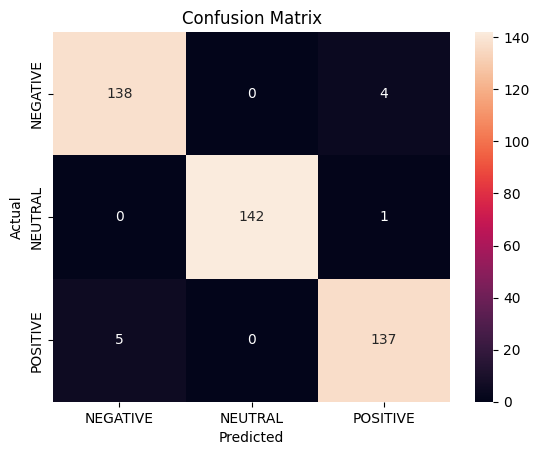

              precision    recall  f1-score   support

    NEGATIVE       0.97      0.97      0.97       142
     NEUTRAL       1.00      0.99      1.00       143
    POSITIVE       0.96      0.96      0.96       142

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


In [5]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


14/14 [==============================] - 0s 5ms/step - loss: 0.1601 - accuracy: 0.9766
Test Accuracy: 97.66%


In [6]:
model.save('eeg_emotion_model.h5')


C:\Users\Dell\.conda\envs\tf215\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


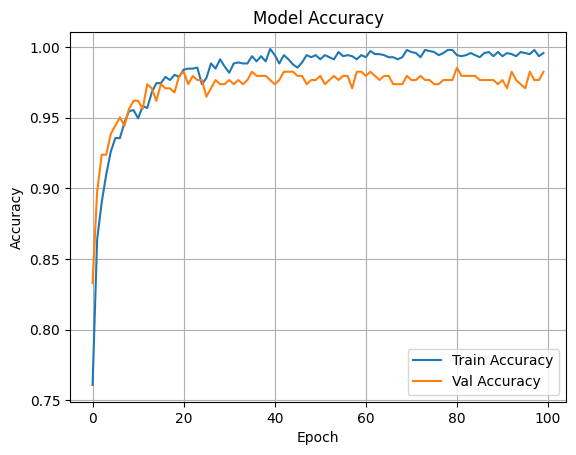

In [7]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Load full dataset
df = pd.read_csv("emotions.csv")

# Take first N rows as "one person" (e.g., first 100 rows)
df_single_person = df.iloc[:100]

# Save to file
df_single_person.to_csv("single_person_eeg.csv", index=False)


In [23]:
import pandas as pd

# Load full dataset
df = pd.read_csv("emotions.csv")

# Remove unwanted columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Simulate a single person's EEG data by taking first N rows
N = 100  # you can change this
df_single_person = df.iloc[:N]

# Save to a new file
df_single_person.to_csv("single_person_eeg.csv", index=False)
print(f"Saved {N} rows as simulated single person data.")


Saved 100 rows as simulated single person data.


In [24]:
import pandas as pd
import numpy as np

# STEP 1: Load the simulated data (you already saved this earlier)
df_single = pd.read_csv("single_person_eeg.csv")

# Drop any 'Unnamed' or 'label' columns if they exist
df_single = df_single.loc[:, ~df_single.columns.str.contains('^Unnamed')]
if 'label' in df_single.columns:
    df_single = df_single.drop(columns=['label'])
if 'emotion' in df_single.columns:
    df_single = df_single.drop(columns=['emotion'])

# STEP 2: Apply preprocessing
# - Use the same VarianceThreshold and StandardScaler as training
X_single_transformed = vt.transform(df_single)
X_single_scaled = scaler.transform(X_single_transformed)

# STEP 3: Predict with trained model
y_single_pred_prob = model.predict(X_single_scaled)
y_single_pred = np.argmax(y_single_pred_prob, axis=1)

# STEP 4: Decode predicted labels
predicted_labels = label_encoder.inverse_transform(y_single_pred)

# STEP 5: Print predictions
for i, label in enumerate(predicted_labels):
    print(f"Sample {i+1}: Predicted Emotion = {label}")


4/4 [==============================] - 0s 4ms/step
Sample 1: Predicted Emotion = NEGATIVE
Sample 2: Predicted Emotion = NEUTRAL
Sample 3: Predicted Emotion = POSITIVE
Sample 4: Predicted Emotion = POSITIVE
Sample 5: Predicted Emotion = NEUTRAL
Sample 6: Predicted Emotion = NEUTRAL
Sample 7: Predicted Emotion = POSITIVE
Sample 8: Predicted Emotion = NEGATIVE
Sample 9: Predicted Emotion = NEUTRAL
Sample 10: Predicted Emotion = NEGATIVE
Sample 11: Predicted Emotion = POSITIVE
Sample 12: Predicted Emotion = NEGATIVE
Sample 13: Predicted Emotion = NEUTRAL
Sample 14: Predicted Emotion = POSITIVE
Sample 15: Predicted Emotion = NEUTRAL
Sample 16: Predicted Emotion = NEGATIVE
Sample 17: Predicted Emotion = POSITIVE
Sample 18: Predicted Emotion = NEUTRAL
Sample 19: Predicted Emotion = NEGATIVE
Sample 20: Predicted Emotion = NEGATIVE
Sample 21: Predicted Emotion = NEGATIVE
Sample 22: Predicted Emotion = NEUTRAL
Sample 23: Predicted Emotion = NEGATIVE
Sample 24: Predicted Emotion = NEGATIVE
Sample

C:\Users\Dell\.conda\envs\tf215\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but VarianceThreshold was fitted without feature names
  warnings.warn(


In [25]:
from collections import Counter

# Count the predicted emotions
emotion_counts = Counter(predicted_labels)

# Print summary
print("\n Prediction Summary:")
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count} samples")



 Prediction Summary:
NEGATIVE: 28 samples
NEUTRAL: 37 samples
POSITIVE: 35 samples


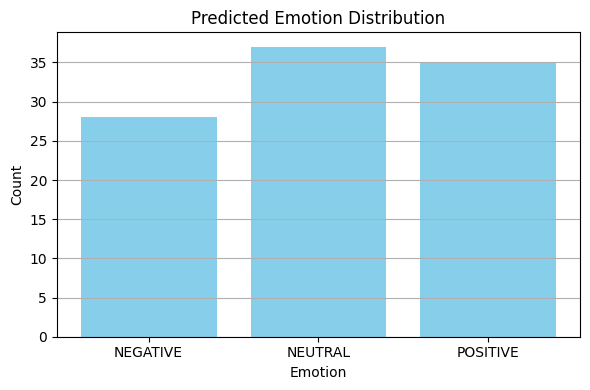

In [26]:
import matplotlib.pyplot as plt

# Plot bar chart of predicted emotions
plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.title("Predicted Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [13]:
import numpy as np

# Number of samples to simulate as one person
N = 1  # you can choose any number <= X_train.shape[0]

# Select first N samples from training set
X_single_person = X_train[:N]
y_single_person_true = y_train[:N]

# Predict with your trained model
y_pred_prob = model.predict(X_single_person)
y_pred = np.argmax(y_pred_prob, axis=1)

# Decode true and predicted labels
y_true_labels = label_encoder.inverse_transform(y_single_person_true)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Print predictions
for i in range(N):
    print(f"Sample {i+1}: True={y_true_labels[i]}, Predicted={y_pred_labels[i]}")


1/1 [==============================] - 0s 52ms/step
Sample 1: True=NEGATIVE, Predicted=NEGATIVE


In [14]:
import joblib
from tensorflow.keras.models import load_model
from sklearn.feature_selection import VarianceThreshold

# If you have this somewhere:
vt = VarianceThreshold(threshold=0.0)
X_train = vt.fit_transform(X_train)  # This fits vt


# Save preprocessing and model once in your notebook:
joblib.dump(vt, 'vt.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
model.save('model.h5')

# Then in your Tkinter script, load them:
vt = joblib.load('vt.pkl')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')
model = load_model('model.h5')


C:\Users\Dell\.conda\envs\tf215\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
